# Multiple Methods for Spam Classification
---
Rita Rezende Borges de Lima <br>
DCC - UFMG

# Main Goals
In this assignment the objective is to classify spam emails through various algorithms such as *Naive Bayes Classification*, *Support Vector Machines*, *Random Forrest Classifier*, *Gradient Boost* and a (find better name) *Neural Network* so to compare using cross-validation the accuracy of the models on the given task. My hypotheses are that the best results will be obtained through the Neural Net. 

## Libraries

Several python modules we're needed. **Pandas** was used for handling the data frames, **re** and multiple **nltk** modules we're used for data preprocessing, **Seaborn** was used to improve report visualization, **scikit-learn** was used to extract features and for its classifiers.

In [1]:
import nltk, re, json, os
import pandas as pd
import seaborn as sns

from IPython.core.display import display, HTML
from gensim.parsing.preprocessing import remove_stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from contractions import contractionsdict
contractions_re=re.compile('(%s)' % '|'.join(contractionsdict.keys()))

from hyperparams import random_forest_hp, svm_hp, grad_boosting_hp


nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
snowball = SnowballStemmer(language='english')
wnl = WordNetLemmatizer()

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.svm import SVC

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ritar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ritar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data Preprocessing

For this assignment, I used the [Spam Mails Dataset](https://www.kaggle.com/venky73/spam-mails-dataset) found on kaggle, which was retrieved from [Enron Spam](http://www2.aueb.gr/users/ion/data/enron-spam/). The data frame consists of three columns, a textual label (ham or spam), the text on the email and a boolean label (0 or 1) . To achieve better results, the textual data, which consists of several e-mails that were either considered legit or spam, was filtered through various process such as lowercasing, expanding contractions, stopword, punctuation and noise removal and stemming. 

### The used dataframe:
In order to be able to compare the processed data with the original one we'll make a copy!

In [2]:
df = pd.read_csv("./data/spam_ham.csv")
cleaned_df = df.copy()
cleaned_df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


### An exemple of a legit email and an exemple of spam:

In [3]:
ham = df[df['label_num'] == 0]
display(HTML("<b>Legit Email:</b>"))
display(HTML(ham.iloc[0]['text']))

display(HTML("<b>Spam:</b>"))
spam = df[df['label_num'] == 1]
display(HTML(spam.iloc[1]['text']))

### Lowercasing

All text will be lower case, so our models won't differ in identical words with different spelling.

In [4]:
example_number = 4

cleaned_df['text'] = cleaned_df['text'].apply(lambda x:x.lower())
cleaned_df['text'][example_number]

"subject: re : indian springs\r\nthis deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i haven ' t received an answer as to whether there is a\r\npredermined price associated with this deal or if teco just lets us know what\r\nwe are giving . i can continue to chase this deal down if you need ."

### Expanding contractions
To have a cleaner text we'll transform contractions (which are quite common in legit emails and spam) in full words. <br>
*Example:* we'll -> we will

In [5]:
def expand_contractions(text,contractionsdict=contractionsdict):
    def replace(match):
        return contractionsdict[match.group(0)]
    return contractions_re.sub(replace, text)

cleaned_df['text'] = cleaned_df['text'].apply(lambda x:expand_contractions(x))
cleaned_df['text'][example_number]

'subject: re : indian springs\r\nthis deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i have not received an answer as to whether there is a\r\npredermined price associated with this deal or if teco just lets us know what\r\nwe are giving . i can continue to chase this deal down if you need .'

### Removing Noise,  Punctuation and Stopwords
Numbers, non-ascii characters and HTML markups are also removed.

In [6]:
def text_cleaning(email):
    email=re.sub("(<.*?>)","",email)             # remove html markup
    email=re.sub("(\r\n)|(\r)|(\n)"," ",email)
    email=re.sub("[^A-Za-z ]","",email)          #remove non-ascii and digits
    email=re.sub(' +', ' ', email)               #remove extra whitespaces
    return email

cleaned_df['text'] = cleaned_df['text'].apply(lambda x:text_cleaning(x))
cleaned_df['text'] = cleaned_df['text'].apply(lambda x:x.translate(str.maketrans('', '', punctuation)))
cleaned_df['text'] = cleaned_df['text'].apply(lambda x:remove_stopwords(x))

cleaned_df['text'][example_number]

'subject indian springs deal book teco pvr revenue understanding teco sends check received answer predermined price associated deal teco lets know giving continue chase deal need'

### Stemming
To improve results we can group together the inflected forms of a word so they can be analysed as a single item, identified by its root.

In [7]:
def stem_texts(email):  
    return (" ").join([snowball.stem(word) for word in word_tokenize(email)])
    
cleaned_df['text'] = cleaned_df['text'].apply(lambda x:stem_texts(x))
cleaned_df['text'][example_number]

'subject indian spring deal book teco pvr revenu understand teco send check receiv answer predermin price associ deal teco let know give continu chase deal need'

### Saving the preprocessed dataframe
The data will be saved in a file, *preprocessed_spam_ham*, so all our models can use it!

In [8]:
cleaned_df.to_csv("./data/preprocessed_spam_ham.csv")

# Classifying spam in emails using Naive Bayes Methods

According to the Scikit-Learn documentation, 

> Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable. 

The Naive Bayes' Theorem finds the probability of an event occurring given the probability of another event that has already occurred.

So given a class variable *Y* and a dependent feature vector *X*<sub>1</sub>... *X*<sub>n</sub>:

![image.png](./images/bayes_theorem.png)

Assuming conditional independence such that:

![image.png](./images/assumption.png)

For all *i* this relationship is simplified to

![image.png](./images/simplification.png)

Since *P(X*<sub>1</sub>,..., *X*<sub>N</sub>*)* is constant for each input, the following classification rule is valid:

![image.png](./images/classification.png)

## Exploratory Data Analysis

As seen bellow there are way more legit emails then spam, to handle with the imbalanced dataset we're going to resample it so to use it in the *Multinomial Naive Bayes* and we're also going to use the *Complement Naive Bayes*, which is particularly suited for imbalanced data sets.

In [9]:
df = pd.read_csv("./data/preprocessed_spam_ham.csv")

df_spam = df[df['label']=='spam']
df_ham = df[df['label']=='ham']

print('Amount of hams: ', len(df_ham),' Amount of spams: ', len(df_spam))

Amount of hams:  3672  Amount of spams:  1499


## Multinomial Naive Bayes and Resampling data
Throught the function *resample* in the **scikit-learn** module, observations in the larger class (hams) will be randomly removed to prevent its signal from dominating the learning algorithm.

In [10]:
df_ham_downsampled = resample(df_ham, replace=False, n_samples=len(df_spam), random_state=42)
resampled_df = pd.concat([df_ham_downsampled, df_spam])

### Train and Test Split 

Through the function *train_test_split* in the **scikit-learn** module, we will split the data frame in proportions 20-80.

In [11]:
x_train_rs, x_test_rs, y_train_rs, y_test_rs = train_test_split(resampled_df['text'], resampled_df['label_num'], test_size = 0.2, random_state = 42)

### Feature Extraction

We are going to use the function *TfidfVectorizer* from the **scikit-learn** module to extract features.

In [12]:
vectorizer_rs = TfidfVectorizer()
features_train_transformed_rs = vectorizer_rs.fit_transform(x_train_rs.tolist()) 
features_test_transformed_rs  = vectorizer_rs.transform(x_test_rs)

### Train our Naive Bayes Model

We'll fit the **scikit-learning** *Naive Bayes* model, the *MultinomialNB* function, to our *TF-IDF* vector version of x_train, and the true output labels stored in y_train.

In [13]:
classifier = MultinomialNB()
classifier.fit(features_train_transformed_rs, y_train_rs)

MultinomialNB()

### Measuring Accuracy 

Finally, using our test sets we'll evalue the model accuracy using built-in functions from the **scikit** library.

Accuracy Score : 0.9733333333333334
F-Measure: 0.973


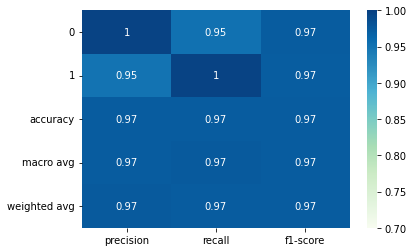

In [14]:
labels = classifier.predict(features_test_transformed_rs)
actual = y_test_rs.tolist()
score_2 = f1_score(actual, labels, average = 'binary')

print ('Accuracy Score :',accuracy_score(actual, labels))
print('F-Measure: %.3f' % score_2)


clf_report = classification_report(actual, labels, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="GnBu", vmin=0.70, vmax=1)
None

## Complement Naive Bayes

### Train and Test Split 

Through the function *train_test_split* in the **scikit-learn** module, we will split the data frame in proportions 20-80.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label_num'], test_size = 0.2, random_state = 42)

### Feature Extraction

We are going to use the function *TfidfVectorizer* from the **scikit-learn** module to extract features.

In [16]:
x_train_list = x_train.tolist()
vectorizer = TfidfVectorizer()
features_train_transformed = vectorizer.fit_transform(x_train_list) #gives tf idf vector for x_train
features_test_transformed  = vectorizer.transform(x_test) #gives tf idf vector for x_test

### Train our Naive Bayes Model

We'll fit the **scikit-learning** *Naive Bayes* model, the *ComplementNB* function, to our *TF-IDF* vector version of x_train, and the true output labels stored in y_train.

In [17]:
classifier = ComplementNB()
classifier.fit(features_train_transformed, y_train)

ComplementNB()

### Measuring Accuracy 

Finally, using our test sets we'll evalue the model accuracy using built-in functions from the **scikit** library.### Measuring Accuracy 

Accuracy Score : 0.9719806763285024
F-Measure: 0.949


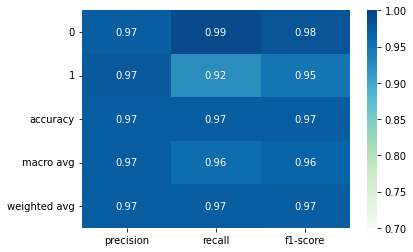

In [18]:
labels = classifier.predict(features_test_transformed)
actual = y_test.tolist()
score_2 = f1_score(actual, labels, average = 'binary')

print ('Accuracy Score :',accuracy_score(actual, labels))
print('F-Measure: %.3f' % score_2)

clf_report = classification_report(actual, labels, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="GnBu", vmin=0.70, vmax=1)
None

# Classifying spam in emails using a Random Forest Classifier.

According to the Scikit-Learn documentation, 

> A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Decision trees are a component of a random forest algorithm. The former is a technique that forms a tree-like structure that consists of three components: decision nodes, leaf nodes, and a root node. In the algorithm we divide the input dataset into branches, which recursively segregate into other branches until a leaf node is attained. The nodes in the decision tree represent attributes that are used for predicting the outcome.  

The main difference between the decision tree algorithm and the random forest algorithm is that establishing root nodes and segregating nodes is done randomly in the latter. The random forest employs the bagging method to generate the required prediction. Bagging involves using different samples of data (training data) rather than just one sample. A training dataset comprises observations and features that are used for making predictions. The decision trees produce different outputs, depending on the training data fed to the random forest algorithm. These outputs will be ranked, and the highest will be selected as the final output.


### Obtaining the Best Set of Hyperparameters

We'll fit the **scikit-learning**,  *RandomForestClassifier* model,  to our *TF-IDF* vector version of x_train, and the true output labels stored in y_train. Since we are dealing with the same dataframe multiple times we'll use the same vector of extracted features from the dataframe with resampling done in the last step.

To obtain better results since the *Random Forest* has multiple hyper-parameters we will use the *RandomizedSearchCV* module so to obtain the best set of hyperparameters.

In [19]:
if os.path.isfile("./data/random_forest_hp.txt"):
    
    print("Best set of HP has already been calculated:")
    with open("./data/random_forest_hp.txt") as f:
        data = f.read()

    best_p = json.loads(data)

else:
    
    print("Calculating best set of HP...")
    
    rfclassifier = RandomForestClassifier()
    rsearch = RandomizedSearchCV(rfclassifier, random_forest_hp)
    search = rsearch.fit(features_train_transformed_rs, y_train_rs)
    rfclassifier.fit(features_train_transformed_rs, y_train_rs)

    best_p, best_s = search.best_params_, search.best_score_
    
    with open("./data/random_forest_hp.txt", 'w') as convert_file:
     convert_file.write(json.dumps(best_p))
    
    print('Best Score: ', best_s)
print ('Best Params: ', best_p)

Best set of HP has already been calculated:
Best Params:  {'min_samples_split': 200, 'min_samples_leaf': 20, 'max_depth': 10, 'criterion': 'entropy'}


### Training our Classifier

Using the dictionary of best set of hyper-parameters obtained on the previous step we will train our optimal model.

In [20]:
rfclassifier = RandomForestClassifier(criterion = best_p['criterion'], 
                                      max_depth = best_p['max_depth'], 
                                      min_samples_split = best_p['min_samples_split'], 
                                      min_samples_leaf = best_p['min_samples_leaf'])

rfclassifier.fit(features_train_transformed_rs, y_train_rs)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       min_samples_split=200)

### Measuring Accuracy 

Finally, using our test sets we'll evalue the model accuracy using built-in functions from the **scikit** library.

Accuracy Score : 0.9216666666666666
F-Measure: 0.924


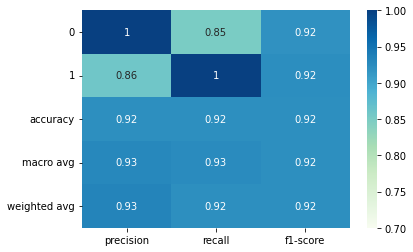

In [21]:
labels = rfclassifier.predict(features_test_transformed_rs)
actual = y_test_rs.tolist()
score_2 = f1_score(actual, labels, average = 'binary')

print ('Accuracy Score :',accuracy_score(actual, labels))
print('F-Measure: %.3f' % score_2)


clf_report = classification_report(actual, labels, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="GnBu", vmin=0.70, vmax=1)
None

# Classifying spam in emails using a Support Vector Machine

According to the Scikit-Learn documentation, 

> A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification, regression or other tasks. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier.

In the Support Vector Machine the data will be categorized in points that may be stated in a finite-dimensional space. Because it may happen that the sets to discriminate are not linearly separable in that space, the original finite-dimensional space is mapped into a much higher-dimensional space, presumably making the separation easier in that space. To keep the computational cost efficient, these mappings used in our model ensure that dot products of pairs of input data vectors may be computed easily in terms of the variables in the original space, by defining them in terms of a kernel function that suits the problem. The hyperplanes in the higher-dimensional space are defined as the set of points whose dot product with a vector in that space is constant, where such a set of vectors is an orthogonal (and thus minimal) set of vectors that defines a hyperplane. 

### Obtaining the Best Set of Hyperparameters

We'll fit the **scikit-learning**,  *RandomForestClassifier* model,  to our *TF-IDF* vector version of x_train, and the true output labels stored in y_train. Since we are dealing with the same dataframe multiple times we'll use the same vector of extracted features from the dataframe with resampling done in the last step.

To obtain better results since the *Random Forest* has multiple hyper-parameters we will use the *RandomizedSearchCV* module so to obtain the best set of hyperparameters.

In [22]:
if os.path.isfile("./data/support_vector_hp.txt"):
    
    print("Best set of HP has already been calculated:")
    with open("./data/support_vector_hp.txt") as f:
        data = f.read()

    best_p = json.loads(data)

else:
    
    print("Calculating best set of HP...")

    sv_classifier = SVC()

    rsearch = RandomizedSearchCV(sv_classifier, svm_hp)
    search = rsearch.fit(features_train_transformed_rs, y_train_rs)

    sv_classifier.fit(features_train_transformed_rs, y_train_rs)

    best_p, best_s = search.best_params_, search.best_score_
    
    with open("./data/support_vector_hp.txt", 'w') as convert_file:
     convert_file.write(json.dumps(best_p))
    
    print('Best Score: ', best_s)
print ('Best Params: ', best_p)

Best set of HP has already been calculated:
Best Params:  {'shrinking': True, 'kernel': 'linear', 'gamma': 'auto', 'degree': 3}


### Training our Classifier

Using the dictionary of best set of hyper-parameters obtained on the previous step we will train our optimal model.

In [23]:
sv_classifier = SVC(kernel = best_p['kernel'], 
                                      degree = best_p['degree'], 
                                      gamma = best_p['gamma'], 
                                      shrinking = best_p['shrinking'])

sv_classifier.fit(features_train_transformed_rs, y_train_rs)

SVC(gamma='auto', kernel='linear')

### Measuring Accuracy 

Finally, using our test sets we'll evalue the model accuracy using built-in functions from the **scikit** library.

Accuracy Score : 0.985
F-Measure: 0.984


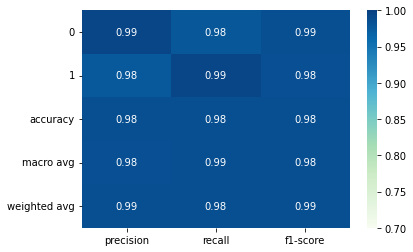

In [24]:
labels = sv_classifier.predict(features_test_transformed_rs)
actual = y_test_rs.tolist()
score_2 = f1_score(actual, labels, average = 'binary')

print ('Accuracy Score :',accuracy_score(actual, labels))
print('F-Measure: %.3f' % score_2)


clf_report = classification_report(actual, labels, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="GnBu", vmin=0.70, vmax=1)
None

# Classifying spam in emails using a Gradient Boosting

According to the Scikit-Learn documentation,

> Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions. GBDT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems in a variety of areas including Web search ranking and ecology.

beautiful text about gradient boosting

https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting

### Obtaining the Best Set of Hyperparameters

We'll fit the **scikit-learning**,  *RandomForestClassifier* model,  to our *TF-IDF* vector version of x_train, and the true output labels stored in y_train. Since we are dealing with the same dataframe multiple times we'll use the same vector of extracted features from the dataframe with resampling done in the last step.

To obtain better results since the *Random Forest* has multiple hyper-parameters we will use the *RandomizedSearchCV* module so to obtain the best set of hyperparameters.

In [25]:
if os.path.isfile("./data/gradient_boosting_hp.txt"):
    
    print("Best set of HP has already been calculated:")
    with open("./data/gradient_boosting_hp.txt") as f:
        data = f.read()

    best_p = json.loads(data)

else:
    
    print("Calculating best set of HP...")
    gb_classifier = GradientBoostingClassifier()

    rsearch = RandomizedSearchCV(gb_classifier, grad_boosting_hp)
    search = rsearch.fit(features_train_transformed_rs, y_train_rs)

    gb_classifier.fit(features_train_transformed_rs, y_train_rs)

    best_p, best_s = search.best_params_, search.best_score_
    
    with open("./data/gradient_boosting_hp.txt", 'w') as convert_file:
     convert_file.write(json.dumps(best_p))
    
    print('Best Score: ', best_s)
print ('Best Params: ', best_p)


Calculating best set of HP...


C:\Users\ritar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ritar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ritar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\

Best Score:  0.9574678148921365
Best Params:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3, 'loss': 'deviance', 'criterion': 'friedman_mse'}


### Training our Classifier

Using the dictionary of best set of hyper-parameters obtained on the previous step we will train our optimal model.

In [26]:
gb_classifier = GradientBoostingClassifier(loss = best_p['loss'], 
                                      n_estimators = best_p['n_estimators'], 
                                      criterion = best_p['criterion'], 
                                      max_depth = best_p['max_depth'], 
                                      min_samples_split = best_p['min_samples_split'], 
                                      min_samples_leaf = best_p['min_samples_leaf'])

gb_classifier.fit(features_train_transformed_rs, y_train_rs)

GradientBoostingClassifier(min_samples_leaf=7, min_samples_split=5,
                           n_estimators=200)

### Measuring Accuracy 

Finally, using our test sets we'll evalue the model accuracy using built-in functions from the **scikit** library.

Accuracy Score : 0.955
F-Measure: 0.955


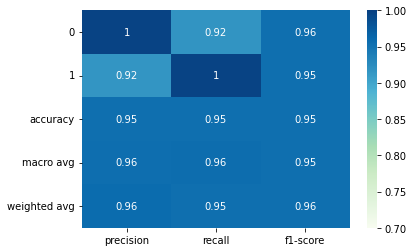

In [27]:
labels = gb_classifier.predict(features_test_transformed_rs)
actual = y_test_rs.tolist()
score_2 = f1_score(actual, labels, average = 'binary')

print ('Accuracy Score :',accuracy_score(actual, labels))
print('F-Measure: %.3f' % score_2)


clf_report = classification_report(actual, labels, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="GnBu", vmin=0.70, vmax=1)
None